A lot of messey playing and exploration. Trying to make sense of how the TRACR compiler works.

['BOS', 3, 2, 1]
TransformerConfig(num_heads=1, num_layers=4, key_size=12, mlp_hidden_size=30, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x000002BBF89CF550>, layer_norm=False, causal=False)


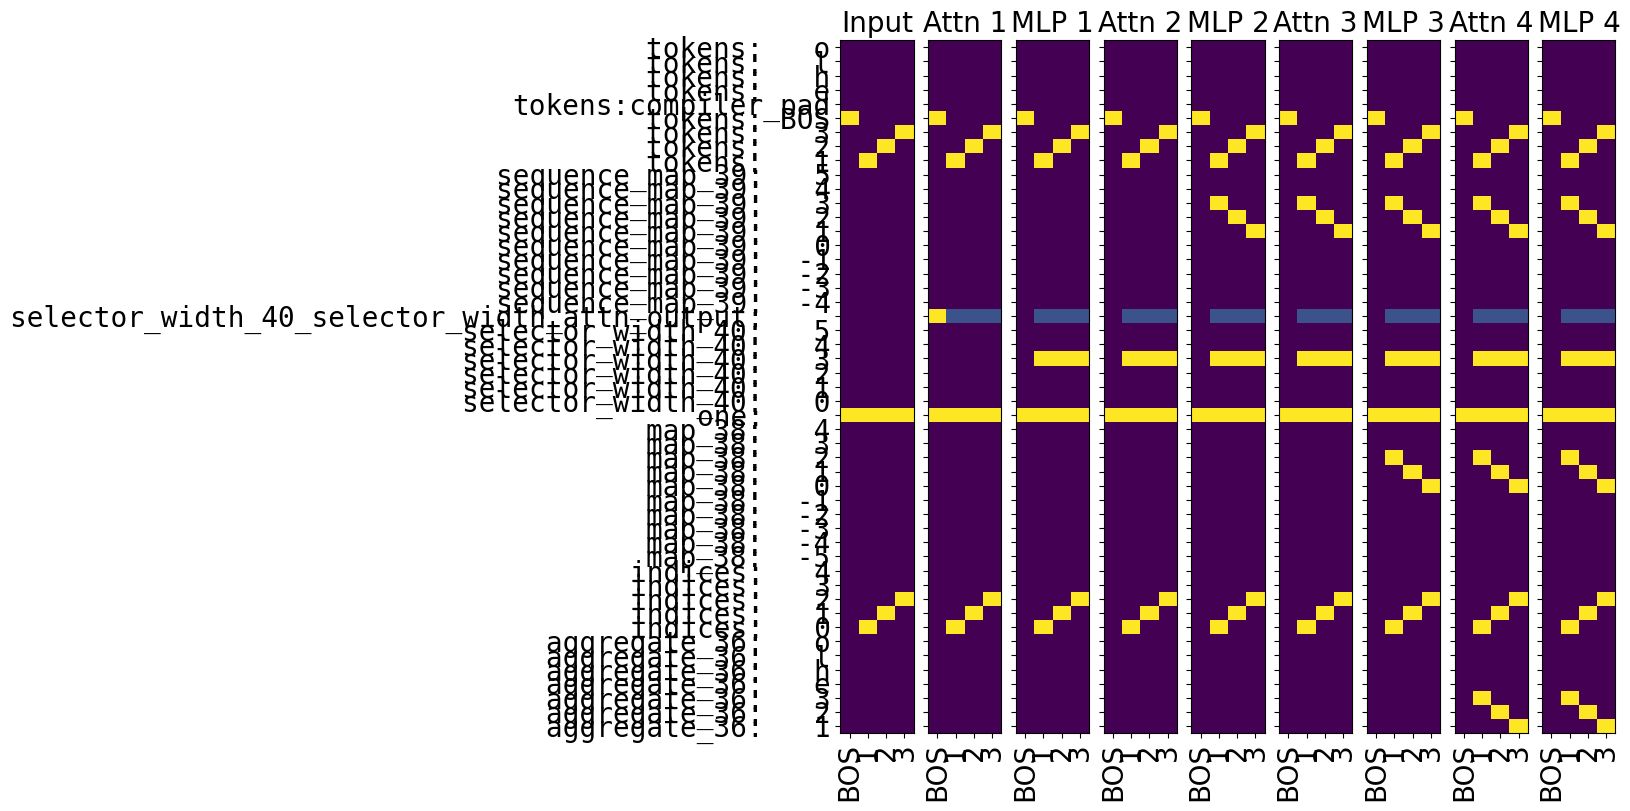

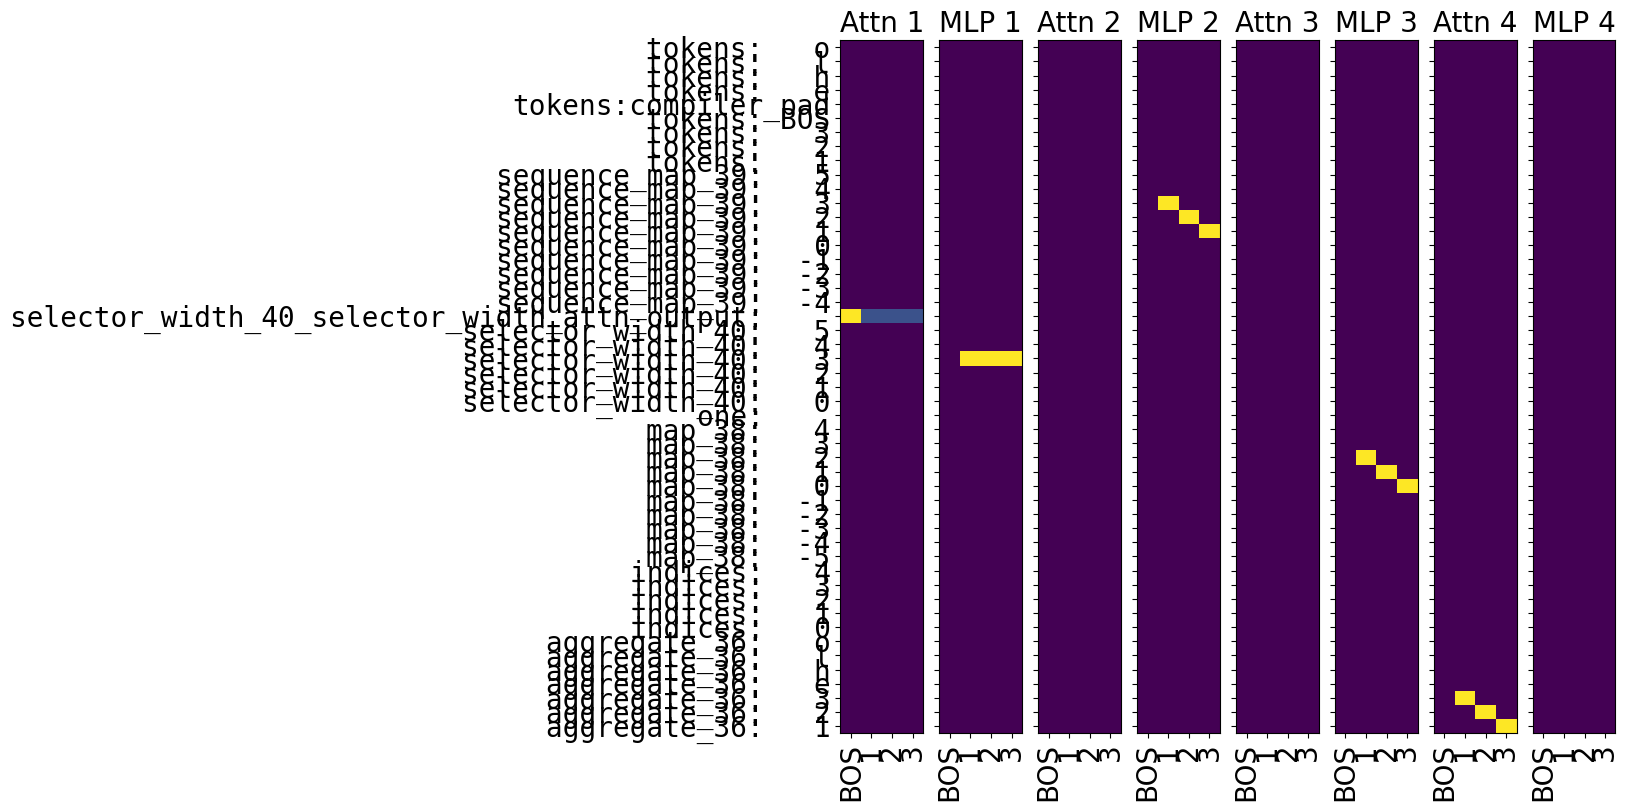

In [149]:
from tracr.rasp import rasp
from tracr.compiler import compiling
import jax
import jax.numpy as jnp
from jax import tree_map
import numpy as np

def make_length():
  all_true_selector = rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.TRUE)
  return rasp.SelectorWidth(all_true_selector)

length = make_length()  # `length` is not a primitive in our implementation.
opp_index = length - rasp.indices - 1
flip = rasp.Select(rasp.indices, opp_index, rasp.Comparison.EQ)
reverse = rasp.Aggregate(flip, rasp.tokens)

bos = "BOS"
model = compiling.compile_rasp_to_model(
    reverse,
    vocab={1, 2, 3, "h", "e", "l", "o"},
    max_seq_len=5,
    compiler_bos=bos,
)

out = model.apply([bos, 1, 2, 3])
print(out.decoded)

# Function to print summary
def model_summary(params):
    for name, value in tree_map(lambda x: (x.shape, x.size), params).items():
      try:
        print(f"{name}: shape = {value['w'][0]}, size = {value['w'][1]}")
      except:
        print(f"{name}: shape = {value}")

# Print the summary
print(model.model_config)
# model_summary(model.params)
# print(model.params['transformer/layer_3/attn/query'])

# FOR VISUALIZIN THE RESIDUAL STREAM
import matplotlib.pyplot as plt
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)
  
plot_residuals_and_input(
  model=model,
  inputs=[bos, 1,2,3],
  figsize=(10, 9)
)

plot_layer_outputs(
  model=model,
  inputs=[bos, 1,2,3],
  figsize=(10, 9)
)

In [152]:
out = model.apply([bos, "h", "e", "l", "l", "o"])
print(out.decoded)

['BOS', 'o', 'l', 'l', 'e', 'h']


In [5]:
list(model.params.keys())

['pos_embed',
 'token_embed',
 'transformer/layer_0/attn/key',
 'transformer/layer_0/attn/linear',
 'transformer/layer_0/attn/query',
 'transformer/layer_0/attn/value',
 'transformer/layer_0/mlp/linear_1',
 'transformer/layer_0/mlp/linear_2',
 'transformer/layer_1/attn/key',
 'transformer/layer_1/attn/linear',
 'transformer/layer_1/attn/query',
 'transformer/layer_1/attn/value',
 'transformer/layer_1/mlp/linear_1',
 'transformer/layer_1/mlp/linear_2',
 'transformer/layer_2/attn/key',
 'transformer/layer_2/attn/linear',
 'transformer/layer_2/attn/query',
 'transformer/layer_2/attn/value',
 'transformer/layer_2/mlp/linear_1',
 'transformer/layer_2/mlp/linear_2',
 'transformer/layer_3/attn/key',
 'transformer/layer_3/attn/linear',
 'transformer/layer_3/attn/query',
 'transformer/layer_3/attn/value',
 'transformer/layer_3/mlp/linear_1',
 'transformer/layer_3/mlp/linear_2']

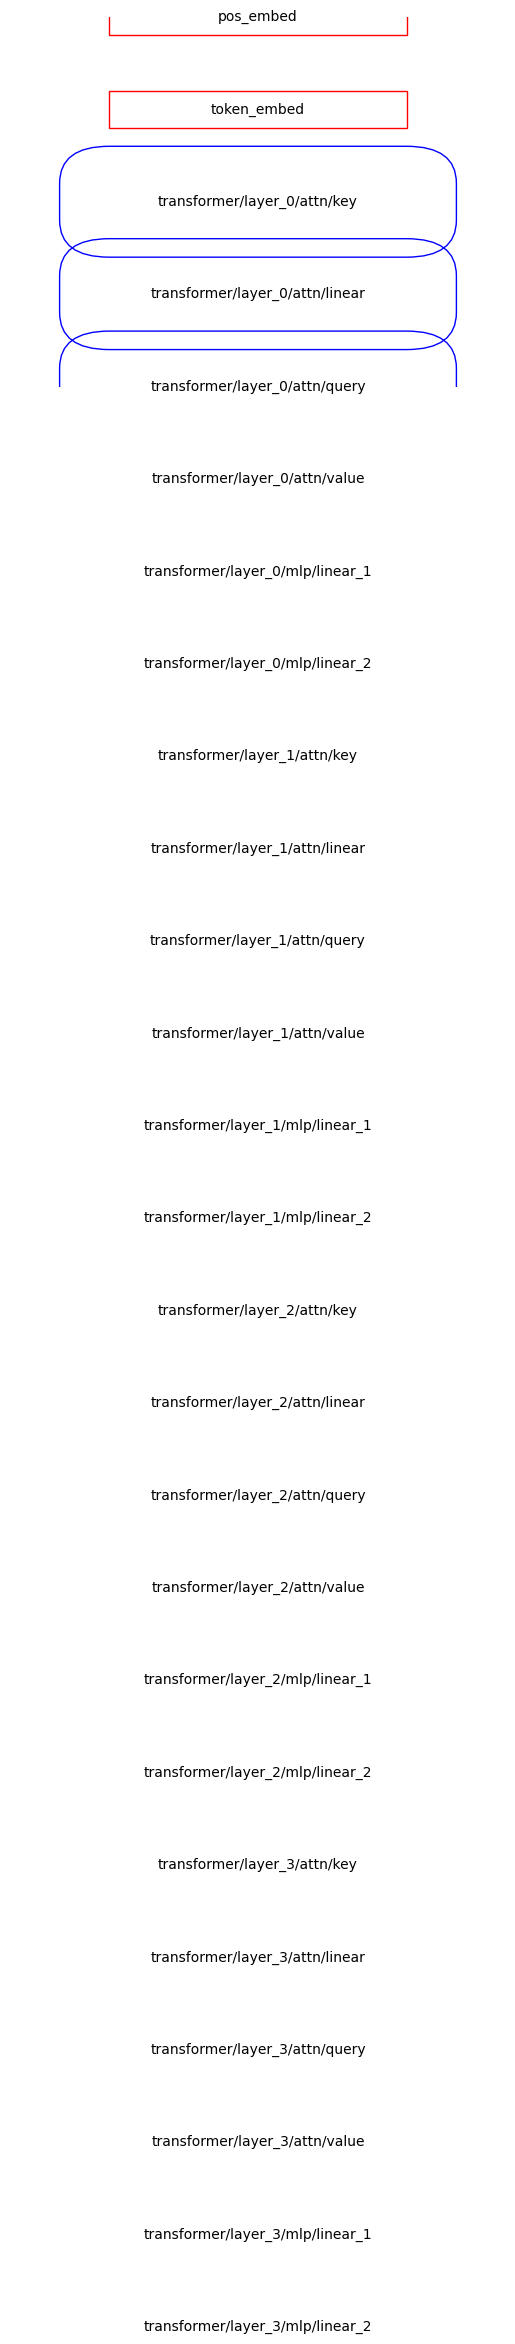

In [9]:
# draw a graph of the model architecture
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_layer(ax, center, width, height, layer_type):
    """ Draws a single layer as a rectangle or rounded rectangle. """
    if "/mlp/" in layer_type or "embed" in layer_type:
        rect = patches.Rectangle((center[0] - width / 2, center[1] - height / 2), width, height, linewidth=1, edgecolor='r', facecolor='none')
    elif "/attn/" in layer_type:
        rect = patches.FancyBboxPatch((center[0] - width / 2, center[1] - height / 2), width, height, boxstyle="round,pad=0.1", linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(center[0], center[1], layer_type, horizontalalignment='center', verticalalignment='center')

def draw_transformer_model():
    """ Draws the architecture of a haiku transformer model. """
    fig, ax = plt.subplots()

    # Assuming a simple architecture with alternating Attention and MLP layers
    layers = list(model.params.keys())
    layer_height = 0.1
    layer_width = 0.6
    spacing = 0.15

    for i, layer in enumerate(layers):
        center = (0.5, 1 - (i * (layer_height + spacing)))
        draw_layer(ax, center, layer_width, layer_height, layer)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

draw_transformer_model()


['B', 1, 1, 2, 2, 1]


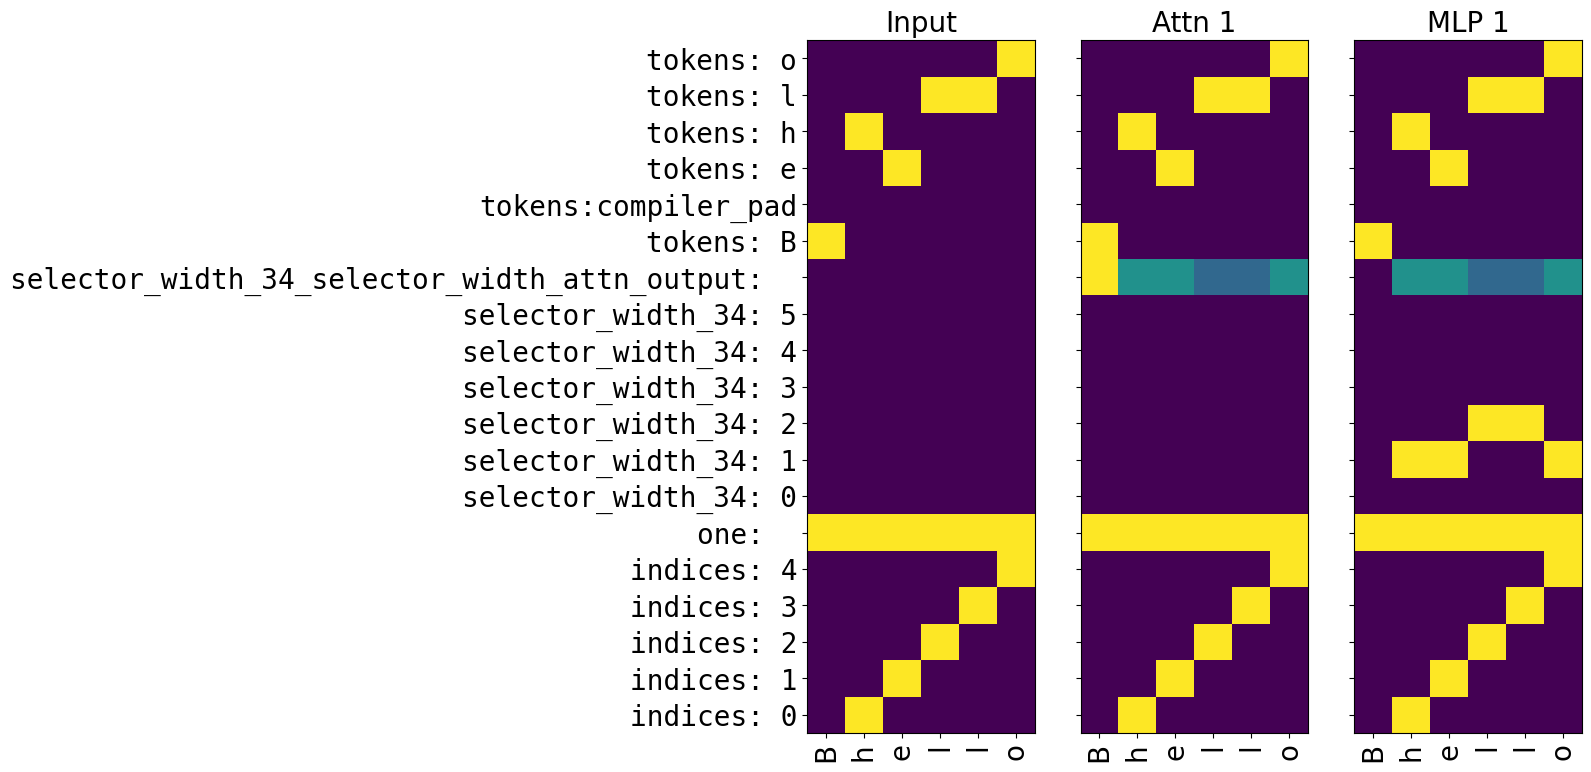

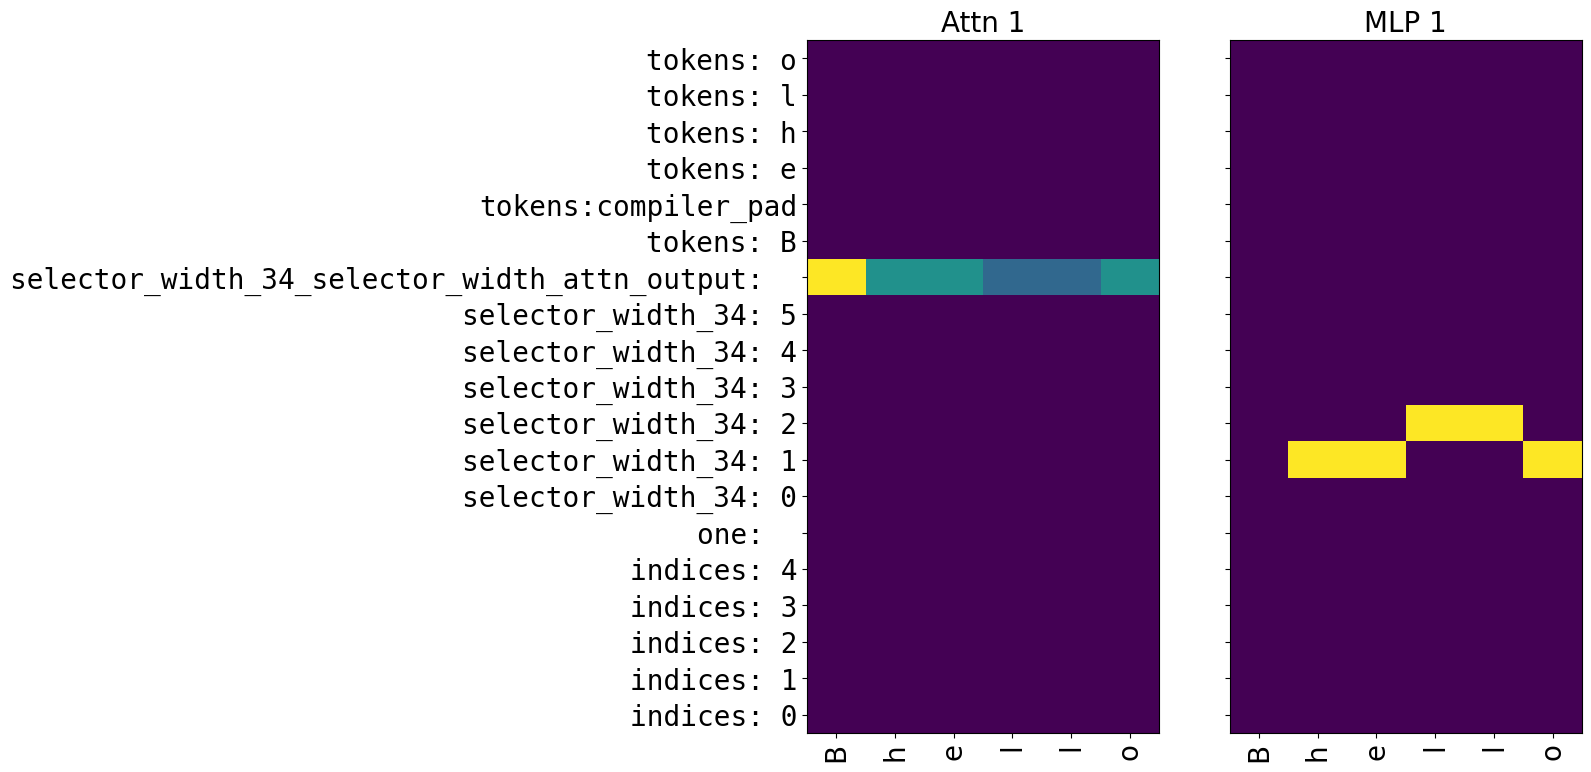

In [34]:
# now create a model that computes histograms
from tracr.rasp import rasp
from tracr.compiler import compiling
import jax
import jax.numpy as jnp
from jax import tree_map
import numpy as np

# HELPER FUNCTIONS FOR VISUALIZATION
import matplotlib.pyplot as plt
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)
  
# RASP IMPLEMENTATION

hist = rasp.SelectorWidth(rasp.Select(rasp.tokens, rasp.tokens, rasp.Comparison.EQ))

bos = "B"
model = compiling.compile_rasp_to_model(
    hist,
    vocab={"h", "e", "l", "o"},
    max_seq_len=5,
    compiler_bos=bos,
)

out = model.apply(bos+"hello")
print(out.decoded)

plot_residuals_and_input(
  model=model,
  inputs=bos+"hello",
  figsize=(10, 9)
)

plot_layer_outputs(
  model=model,
  inputs=bos+"hello",
  figsize=(10, 9)
)

Plan for understanding: verify the attention mechanism works, then understand how it was constructed. verify that mlp works, then understand how it was constructed.

then understand how aggregate works and is constructed.

then understand where all the sequence_maps come from in the reverse example

In [31]:
def has_prev(seq: rasp.SOp) -> rasp.SOp:
    prev_copy = rasp.SelectorAnd(
        rasp.Select(seq, seq, rasp.Comparison.EQ),
        rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.LT),
    )
    return rasp.Aggregate(prev_copy, rasp.Full(1), default=0) > 0

has_prev(rasp.tokens)("hello")

[False, False, False, True, False]

In [79]:
model

AssembledTransformerModel(forward=<function without_apply_rng.<locals>.apply_fn at 0x000002BB88473DC0>, get_compiled_model=<function assemble_craft_model.<locals>.get_compiled_model at 0x000002BB84BB19D0>, params={'pos_embed': {'embeddings': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]], dtype=float32)}, 'token_embed': {'embeddings': Array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

In [35]:
list(model.params.keys())

['pos_embed',
 'token_embed',
 'transformer/layer_0/attn/key',
 'transformer/layer_0/attn/linear',
 'transformer/layer_0/attn/query',
 'transformer/layer_0/attn/value',
 'transformer/layer_0/mlp/linear_1',
 'transformer/layer_0/mlp/linear_2']

In [36]:
list(enumerate((model.residual_labels)))

[(0, 'indices:0'),
 (1, 'indices:1'),
 (2, 'indices:2'),
 (3, 'indices:3'),
 (4, 'indices:4'),
 (5, 'one'),
 (6, 'selector_width_34:0'),
 (7, 'selector_width_34:1'),
 (8, 'selector_width_34:2'),
 (9, 'selector_width_34:3'),
 (10, 'selector_width_34:4'),
 (11, 'selector_width_34:5'),
 (12, 'selector_width_34_selector_width_attn_output'),
 (13, 'tokens:B'),
 (14, 'tokens:compiler_pad'),
 (15, 'tokens:e'),
 (16, 'tokens:h'),
 (17, 'tokens:l'),
 (18, 'tokens:o')]

In [100]:
out.input_embeddings[0].transpose()

Array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [104]:
print(model.params['token_embed']['embeddings'].shape)
tembed = model.params['token_embed']['embeddings'].transpose()
intoks = tembed[:, [0,-3,-4,-2,-2,-1]]
intoks

(6, 19)


Array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [86]:
print(model.params['pos_embed']['embeddings'].shape)
model.params['pos_embed']['embeddings'].transpose()

(6, 19)


Array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [39]:
print(model.params['transformer/layer_0/attn/key']['w'].shape)
model.params['transformer/layer_0/attn/key']

(19, 6)


{'b': Array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'w': Array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.]], dtype=float32)}

In [45]:
print(model.params['transformer/layer_0/attn/linear']['w'].shape)
model.params['transformer/layer_0/attn/linear']

(6, 19)


{'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=float32),
 'w': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], dtype=float32)}

In [40]:
print(model.params['transformer/layer_0/attn/query']['w'].shape)
model.params['transformer/layer_0/attn/query']

(19, 6)


{'b': Array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'w': Array([[  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 100.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.],
        [  0.,   0.,   0., 100.,   0.,   0.],
        [  0.,   0.,   0.,   0., 100.,   0.]], dtype=float32)}

In [41]:
print(model.params['transformer/layer_0/attn/value']['w'].shape)
model.params['transformer/layer_0/attn/value']

(19, 6)


{'b': Array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'w': Array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], dtype=float32)}

In [106]:
# trying to piece everything together - this is the input layer
embed = intoks.transpose() + model.params['pos_embed']['embeddings']
embed.transpose()

Array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [111]:
(out.input_embeddings == embed).all()

Array(True, dtype=bool)

In [112]:
out.layer_outputs[0][0].transpose()

Array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0

In [148]:
# piecing together the attention layer

# HELPER NONLINEARITY FUNCTIONS
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtracting np.max(z) for numerical stability
    return exp_z / exp_z.sum(axis=0)

def relu(x):
    return max(0, x)

# ATTENTION
# wqk = np.dot(model.params['transformer/layer_0/attn/query']['w'], model.params['transformer/layer_0/attn/key']['w'].transpose())
# wov = np.dot(model.params['transformer/layer_0/attn/value']['w'], model.params['transformer/layer_0/attn/linear']['w'])
# wqk_out = np.dot(wqk, out.input_embeddings[0].transpose())
# wov_out = np.dot(wov.transpose(), out.input_embeddings[0].transpose())

k = np.dot(out.input_embeddings[0], model.params['transformer/layer_0/attn/key']['w'])
print(k)
q = np.dot(out.input_embeddings[0], model.params['transformer/layer_0/attn/query']['w'])
print(q)
v = np.dot(out.input_embeddings[0], model.params['transformer/layer_0/attn/value']['w'])
z = np.dot(q, k.transpose()) + v
print(z)
out_attn1 = np.dot(model.params['transformer/layer_0/attn/linear']['w'].transpose(), z.transpose())
out_attn1

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
[[100.   0.   0.   0.   0.   0.]
 [100.   0. 100.   0.   0.   0.]
 [100. 100.   0.   0.   0.   0.]
 [100.   0.   0. 100.   0.   0.]
 [100.   0.   0. 100.   0.   0.]
 [100.   0.   0.   0. 100.   0.]]
[[101.   0.   0.   0.   0.   0.]
 [100. 100.   0.   0.   0.   0.]
 [100.   0. 100.   0.   0.   0.]
 [100.   0.   0. 100. 100.   0.]
 [100.   0.   0. 100. 100.   0.]
 [100.   0.   0.   0.   0. 100.]]


array([[  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [101., 100., 100., 100., 100., 100.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

In [49]:
print(model.params['transformer/layer_0/mlp/linear_1']['w'].shape)
model.params['transformer/layer_0/mlp/linear_1']

(19, 12)


{'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'w': Array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ],
        [  0.      , -17.333334, -18.333334, -21.5     , 

In [50]:
print(model.params['transformer/layer_0/mlp/linear_2']['w'].shape)
model.params['transformer/layer_0/mlp/linear_2']

(12, 19)


{'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=float32),
 'w': Array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0., -1.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,
         

In [85]:
# mlp output
mlp1 = np.maximum(0, np.dot(model.params['transformer/layer_0/mlp/linear_1']['w'], embed + out_attn1))             
mlp2 = np.maximum(0, np.dot(mlp1, model.params['transformer/layer_0/mlp/linear_2']['w']))
# mlp_out = np.dot(np.dot(out_attn1 + embed, model.params['transformer/layer_0/mlp/linear_1']['w']), model.params['transformer/layer_0/mlp/linear_2']['w'])
mlp_out = mlp2 + embed 
mlp_out.transpose()

# mlp1_out = np.dot(out_attn1, model.params['transformer/layer_0/mlp/linear_1']['w'])
# mlp1_out.transpose()

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)